# Part2

In [ ]:
## 

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from npc_gzip.compressors.base import BaseCompressor
from npc_gzip.compressors.gzip_compressor import GZipCompressor
from npc_gzip.knn_classifier import KnnClassifier

# Define distance metrics
distance_metrics = ['ncd', 'clm', 'cdm', 'mse']


In [2]:
# Function to efficiently load and pre-process data with sample size reduction
def pass_data():
    df = pd.read_csv("train_40k.csv", encoding="latin-1")

    # Reduce sample size if needed
    sample_size=1000
    
    if len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=42)

    df["text"] = df["Text"]
    df["label"] = df["Cat1"]
    return df

def get_data(test_size=0.2, for_compression=False):
    df = pass_data()
    X_train, X_test, y_train, y_test = train_test_split(
        df["text"], df["label"], test_size=test_size, random_state=42
    )
    label_encoder = LabelEncoder()
    train_text = X_train.to_numpy()
    train_labels = label_encoder.fit_transform(y_train.to_numpy())
    test_text = X_test.to_numpy()
    test_labels = label_encoder.fit_transform(y_test.to_numpy())
    return (train_text, train_labels), (test_text, test_labels)



In [3]:
def fit_predict(
    train_text, train_labels, test_text, test_labels, distance_metric, k
):
    compressor = GZipCompressor()
    model = KnnClassifier(
        compressor=compressor,
        training_inputs=train_text,
        training_labels=train_labels,
        distance_metric=distance_metric,
    )
    predictions, labels, _ = model.predict(test_text, k)
    accuracy = classification_report(test_labels, labels.reshape(-1), output_dict=True, zero_division=0)['accuracy']
    return accuracy


In [ ]:
# Define k values to evaluate
k_values = np.arange(1, 21)

# Initialize dictionary to store results
results = {metric: {} for metric in distance_metrics}

# Load data
(train_text, train_labels), (test_text, test_labels) = get_data()

In [28]:
print("The average number of characters in training text is: ", np.mean([len(text) for text in train_text]))
print("The average number of words in training text is: ", np.mean([len(text.split()) for text in train_text]))
print("The number of unique labels is: ", len(np.unique(train_labels)))

The average number of characters in training text is:  463.65875
The average number of words in training text is:  87.43875
The number of unique labels is:  6


In [4]:
# Iterate through distance metrics and k values
for metric in distance_metrics:
    for k in k_values:
        results[metric][k] = fit_predict(train_text, train_labels, test_text, test_labels, metric, k)



Compressing input...: 100%|██████████| 200/200 [00:05<00:00, 39.89it/s]
c:\Users\kio\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kio\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kio\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

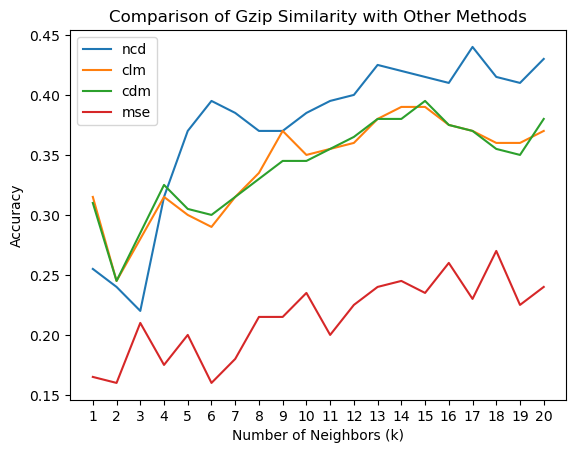

In [6]:
# Plot accuracy vs k for each method
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

for metric, data in results.items():
    sns.lineplot(x = list(data.keys()), y = list(data.values()), label=metric)

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("Comparison of Gzip Similarity with Other Methods")
plt.legend()
plt.show()

In [44]:
max_accuracy_gzip = max(results['ncd'].values())
print("The maximum accuracy for Gzip similarity is: ", max_accuracy_gzip)

The maximum accuracy for Gzip similarity is:  0.44


In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_text)
X_test = vectorizer.transform(test_text)

# Convert labels to integers
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

standard_knn_results = {}

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, train_labels_encoded)
    predictions = knn_model.predict(X_test)
    accuracy = classification_report(test_labels_encoded, predictions, output_dict=True, zero_division=0)['accuracy']
    standard_knn_results[k] = accuracy

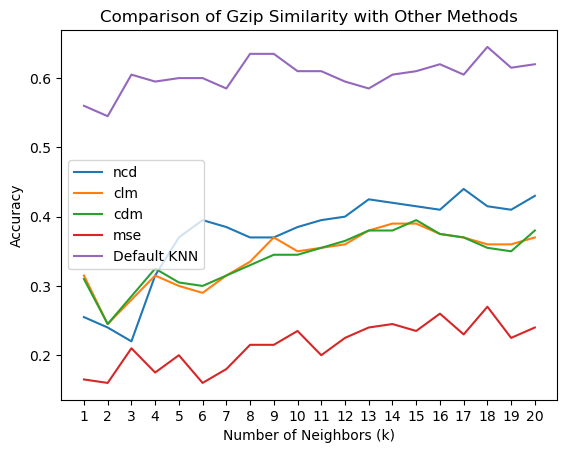

In [13]:
for metric, data in results.items():
    sns.lineplot(x = list(data.keys()), y = list(data.values()), label=metric)

sns.lineplot(x = list(standard_knn_results.keys()), y = list(standard_knn_results.values()), label="Default KNN")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("Comparison of Gzip Similarity with Other Methods")
plt.legend()
plt.show()

In [47]:
max_default_knn_accuracy = max(standard_knn_results.values())
print("The maximum accuracy for default KNN is: ", max_default_knn_accuracy)

The maximum accuracy for default KNN is:  0.645


In [45]:
from sklearn.svm import SVC

model = SVC(kernel="linear")  # Choose the desired kernel function
model.fit(X_train, train_labels_encoded)

# Predict labels for the test data
predictions = model.predict(X_test)

# Evaluate the model using classification report
report = classification_report(test_labels_encoded, predictions, output_dict=True, zero_division=0)

svm_accuracy = report['accuracy']
print("The accuracy of the SVM model is: ", svm_accuracy)


In [29]:
import torch
import random
import numpy as np

seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print(f"Random seed set as {seed}")

torch.cuda.empty_cache()

import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import json
import pandas as pd

Random seed set as 42


In [30]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
num_labels = len(np.unique(train_labels))
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
tokenized_texts = []
from tqdm import tqdm

max_seq_length = 512  # Maximum sequence length for BERT

for text in tqdm(train_text):
    tokenized_texts.append(tokenizer(text, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt'))

100%|██████████| 800/800 [00:01<00:00, 631.28it/s]


In [37]:
# Tokenize the texts and convert them to tensors
from sklearn.metrics import accuracy_score, f1_score, classification_report

input_ids = torch.cat([t['input_ids'] for t in tokenized_texts], dim=0)
attention_mask = torch.cat([t['attention_mask'] for t in tokenized_texts], dim=0)
labels = torch.tensor(train_labels_encoded)

# Create a dataset and data loader
dataset = TensorDataset(input_ids, attention_mask, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 16
lr = 1e-5

train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

c:\Users\kio\Anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [38]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for batch in tqdm(dataloader):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(predictions == labels).item()
            print(labels.cpu())
            total_samples += labels.size(0)


    print(classification_report(predictions.cpu().numpy(), labels.cpu().numpy()))
    return total_loss / len(dataloader), correct_predictions / total_samples

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [40]:
num_epochs = 3
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.2%}")
    model.save_pretrained(f"fine_tuned_bert_epoch_{epoch+1}_lr_{lr}")

# Save the fine-tuned model
model.save_pretrained(f"fine_tuned_bert")

 10%|█         | 1/10 [00:06<01:00,  6.73s/it]

tensor([3, 0, 4, 4, 3, 4, 4, 0, 3, 5, 3, 5, 5, 1, 4, 5])


 20%|██        | 2/10 [00:13<00:52,  6.51s/it]

tensor([3, 0, 3, 3, 3, 3, 3, 5, 4, 0, 3, 2, 5, 3, 3, 0])


 30%|███       | 3/10 [00:19<00:44,  6.43s/it]

tensor([1, 4, 0, 3, 5, 2, 3, 3, 2, 5, 0, 4, 1, 5, 5, 4])


 40%|████      | 4/10 [00:25<00:38,  6.42s/it]

tensor([3, 3, 2, 2, 3, 1, 3, 3, 1, 5, 5, 1, 1, 1, 5, 2])


 50%|█████     | 5/10 [00:32<00:32,  6.43s/it]

tensor([3, 1, 3, 5, 4, 0, 5, 3, 2, 5, 5, 1, 5, 5, 1, 0])


 60%|██████    | 6/10 [00:38<00:25,  6.40s/it]

tensor([4, 5, 5, 3, 2, 2, 4, 3, 5, 3, 5, 1, 3, 2, 5, 0])


 70%|███████   | 7/10 [00:44<00:19,  6.37s/it]

tensor([1, 3, 1, 1, 5, 1, 0, 3, 1, 1, 4, 5, 1, 4, 3, 0])


 80%|████████  | 8/10 [00:51<00:12,  6.38s/it]

tensor([5, 3, 5, 4, 1, 3, 3, 5, 3, 5, 5, 0, 3, 5, 3, 5])


 90%|█████████ | 9/10 [00:57<00:06,  6.39s/it]

tensor([0, 5, 4, 5, 1, 3, 5, 3, 1, 3, 4, 3, 3, 2, 3, 3])


100%|██████████| 10/10 [01:04<00:00,  6.40s/it]

tensor([1, 4, 5, 0, 5, 4, 5, 5, 4, 4, 5, 1, 5, 0, 5, 0])
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         4
           4       0.25      0.50      0.33         2
           5       0.71      0.56      0.63         9

    accuracy                           0.38        16
   macro avg       0.19      0.21      0.19        16
weighted avg       0.43      0.38      0.39        16

Epoch 1/3 - Train Loss: 1.7423 - Val Loss: 1.5881 - Val Accuracy: 48.12%



c:\Users\kio\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kio\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kio\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kio\Anaconda3\Lib\site-packages\sklearn\metrics\_classifica

tensor([3, 0, 4, 4, 3, 4, 4, 0, 3, 5, 3, 5, 5, 1, 4, 5])


 20%|██        | 2/10 [00:13<00:52,  6.51s/it]

tensor([3, 0, 3, 3, 3, 3, 3, 5, 4, 0, 3, 2, 5, 3, 3, 0])


 30%|███       | 3/10 [00:19<00:45,  6.47s/it]

tensor([1, 4, 0, 3, 5, 2, 3, 3, 2, 5, 0, 4, 1, 5, 5, 4])


 40%|████      | 4/10 [00:25<00:38,  6.46s/it]

tensor([3, 3, 2, 2, 3, 1, 3, 3, 1, 5, 5, 1, 1, 1, 5, 2])


 50%|█████     | 5/10 [00:32<00:32,  6.44s/it]

tensor([3, 1, 3, 5, 4, 0, 5, 3, 2, 5, 5, 1, 5, 5, 1, 0])


 60%|██████    | 6/10 [00:38<00:25,  6.43s/it]

tensor([4, 5, 5, 3, 2, 2, 4, 3, 5, 3, 5, 1, 3, 2, 5, 0])


 70%|███████   | 7/10 [00:45<00:19,  6.42s/it]

tensor([1, 3, 1, 1, 5, 1, 0, 3, 1, 1, 4, 5, 1, 4, 3, 0])


 80%|████████  | 8/10 [00:51<00:12,  6.42s/it]

tensor([5, 3, 5, 4, 1, 3, 3, 5, 3, 5, 5, 0, 3, 5, 3, 5])


 90%|█████████ | 9/10 [00:57<00:06,  6.37s/it]

tensor([0, 5, 4, 5, 1, 3, 5, 3, 1, 3, 4, 3, 3, 2, 3, 3])


100%|██████████| 10/10 [01:04<00:00,  6.43s/it]

tensor([1, 4, 5, 0, 5, 4, 5, 5, 4, 4, 5, 1, 5, 0, 5, 0])
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         2
           4       0.50      1.00      0.67         2
           5       0.86      0.60      0.71        10

    accuracy                           0.62        16
   macro avg       0.47      0.52      0.47        16
weighted avg       0.72      0.62      0.65        16

Epoch 2/3 - Train Loss: 1.4515 - Val Loss: 1.2383 - Val Accuracy: 66.88%



c:\Users\kio\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kio\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kio\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kio\Anaconda3\Lib\site-packages\sklearn\metrics\_classifica

tensor([3, 0, 4, 4, 3, 4, 4, 0, 3, 5, 3, 5, 5, 1, 4, 5])


 20%|██        | 2/10 [00:13<00:55,  6.88s/it]

tensor([3, 0, 3, 3, 3, 3, 3, 5, 4, 0, 3, 2, 5, 3, 3, 0])


 30%|███       | 3/10 [00:20<00:47,  6.84s/it]

tensor([1, 4, 0, 3, 5, 2, 3, 3, 2, 5, 0, 4, 1, 5, 5, 4])


 40%|████      | 4/10 [00:27<00:40,  6.81s/it]

tensor([3, 3, 2, 2, 3, 1, 3, 3, 1, 5, 5, 1, 1, 1, 5, 2])


 50%|█████     | 5/10 [00:34<00:34,  6.83s/it]

tensor([3, 1, 3, 5, 4, 0, 5, 3, 2, 5, 5, 1, 5, 5, 1, 0])


 60%|██████    | 6/10 [00:41<00:27,  6.82s/it]

tensor([4, 5, 5, 3, 2, 2, 4, 3, 5, 3, 5, 1, 3, 2, 5, 0])


 70%|███████   | 7/10 [00:48<00:20,  6.89s/it]

tensor([1, 3, 1, 1, 5, 1, 0, 3, 1, 1, 4, 5, 1, 4, 3, 0])


 80%|████████  | 8/10 [00:54<00:13,  6.89s/it]

tensor([5, 3, 5, 4, 1, 3, 3, 5, 3, 5, 5, 0, 3, 5, 3, 5])


 90%|█████████ | 9/10 [01:02<00:07,  7.00s/it]

tensor([0, 5, 4, 5, 1, 3, 5, 3, 1, 3, 4, 3, 3, 2, 3, 3])


100%|██████████| 10/10 [01:08<00:00,  6.89s/it]

tensor([1, 4, 5, 0, 5, 4, 5, 5, 4, 4, 5, 1, 5, 0, 5, 0])
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         2
           4       0.75      1.00      0.86         3
           5       0.86      1.00      0.92         6

    accuracy                           0.88        16
   macro avg       0.72      0.80      0.76        16
weighted avg       0.77      0.88      0.82        16

Epoch 3/3 - Train Loss: 1.1150 - Val Loss: 0.9928 - Val Accuracy: 73.75%



c:\Users\kio\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kio\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kio\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
# To use the fine-tuned model for inference:
loaded_model = BertForSequenceClassification.from_pretrained(f"fine_tuned_bert")
loaded_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [42]:
loaded_model.eval()

all_preds = []

with torch.no_grad():
  for text in tqdm(test_text):
      tokenized_sentence = tokenizer(text, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt')
      input_ids = tokenized_sentence["input_ids"].to(device)
      attention_mask = tokenized_sentence["attention_mask"].to(device)

      outputs = loaded_model(input_ids, attention_mask=attention_mask)
      logits = outputs.logits
      predictions = torch.argmax(logits, dim=1)
      all_preds.extend(predictions.cpu().numpy())

100%|██████████| 200/200 [02:21<00:00,  1.42it/s]


In [49]:
bert_accuracy = classification_report(test_labels_encoded, all_preds, output_dict=True, zero_division=0)['accuracy']
print("The accuracy of the fine-tuned BERT model is: ", bert_accuracy)

The accuracy of the fine-tuned BERT model is:  0.71
